In [2]:
# 🧩 Setup: Import and Configuration
from pathlib import Path
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from timm import create_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import gc
import time
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F
import random
import numpy as np
import os

In [20]:
# Constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 2
EPOCHS = 15
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
USE_MIXUP = True
ALPHA_MIXUP = 0.4
TEMPERATURE = 2.0

# Local Paths
ROOT_DIR = Path("C:/Users/rsriram3/Documents/ind_study")
OUTPUT_DIR = ROOT_DIR / "data"
TRAIN_CSV = OUTPUT_DIR / "train_split_augmented.csv"
TEST_CSV = OUTPUT_DIR / "test_split_augmented.csv"
CHECKPOINT_DIR = OUTPUT_DIR / "best_checkpoints"
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

In [21]:
# Dataset Definition (with engineered features)
class SharedHeadDataset(Dataset):
    def __init__(self, csv_file, root_dir):
        self.data = pd.read_csv(csv_file)
        self.root_dir = Path(root_dir)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = self.root_dir / row.image
        try:
            image = Image.open(img_path)
        except Exception as e:
            print(f"[ Failed to load image: {img_path}, error: {e}")
            return self.__getitem__((idx + 1) % len(self.data))

        if image.mode != 'RGB':
            image = image.convert("RGB")

        transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.85, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image_tensor = transform(image)
        label = int(row.label)

        brightness = torch.tensor(row.brightness_mean, dtype=torch.float32).unsqueeze(0)
        edge_density = torch.tensor(row.edge_density, dtype=torch.float32).unsqueeze(0)
        entropy = torch.tensor(row.entropy, dtype=torch.float32).unsqueeze(0)

        channel_mode = row.channel_mode
        if channel_mode == 'rgb':
            channel_tensor = torch.tensor([1.0, 0.0])
        elif channel_mode == 'ir':
            channel_tensor = torch.tensor([0.0, 1.0])
        else:
            channel_tensor = torch.tensor([0.0, 0.0])

        # aux_features = torch.cat([brightness, edge_density, entropy, channel_tensor], dim=0)
        aux_features = torch.cat([brightness, edge_density, entropy], dim=0)

        return image_tensor, aux_features, label


In [22]:
# Collate Function
def collate_fun(batch):
    images, aux_feats, labels = zip(*batch)
    return torch.stack(images), torch.stack(aux_feats), torch.tensor(labels)

In [23]:
# Model Definition
class ExtendedModel(nn.Module):
    # def __init__(self, backbone_name, num_aux_features=5, num_classes=2): ## ORIGINALLY num_features=5
    def __init__(self, backbone_name, num_aux_features=3, num_classes=2):
        super().__init__()
        self.backbone = create_model(backbone_name, pretrained=True, num_classes=0)
        backbone_output_dim = self.backbone.num_features
        self.backbone.reset_classifier(0)
        self.classifier = nn.Sequential(
            nn.Linear(backbone_output_dim + num_aux_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, aux):
        feats = self.backbone(x)
        combined = torch.cat([feats, aux], dim=1)
        return self.classifier(combined)

# 🧪 Evaluation
def evaluate_model(model, dataloader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for images, aux, labels in dataloader:
            images, aux = images.to(DEVICE), aux.to(DEVICE)
            outputs = model(images, aux)
            preds.extend(torch.argmax(outputs, dim=1).cpu().tolist())
            targets.extend(labels.tolist())
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds)
    rec = recall_score(targets, preds)
    f1 = f1_score(targets, preds)
    cm = confusion_matrix(targets, preds)
    return acc, prec, rec, f1, cm


In [45]:
# Plotting Accuracy
def plot_metrics(train_accs, val_accs, model_name, save_path):
    save_path.mkdir(parents=True, exist_ok=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'Training vs Validation Accuracy - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plot_path = save_path / f'{model_name}_accuracy_plot.png'
    plt.savefig(plot_path)
    plt.show()
    plt.close()

In [25]:
#  Mixup Training
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
## OLD

def mixup_criterion(pred, y_a, y_b, lam):
    return lam * F.cross_entropy(pred, y_a) + (1 - lam) * F.cross_entropy(pred, y_b)

In [ ]:
## NEW

def entropy_loss(logits):
    p = F.softmax(logits, dim=1)
    return -torch.mean(torch.sum(p * torch.log(p + 1e-6), dim=1))

def mixup_criterion(pred, y_a, y_b, lam, entropy_weight=0.05):
    ce_a = F.cross_entropy(pred, y_a, label_smoothing=0.1)
    ce_b = F.cross_entropy(pred, y_b, label_smoothing=0.1)
    ent = entropy_loss(pred)
    return lam * ce_a + (1 - lam) * ce_b + entropy_weight * ent


### ORIGINAL TRAINING PIPELINE - WITHOUT CROSS VALIDATION 

In [ ]:
# Model Training Wrapper (ORIGINAL)
def train_model(model_name, train_csv, test_csv, root_dir, save_path):
    train_ds = SharedHeadDataset(train_csv, root_dir)
    test_ds = SharedHeadDataset(test_csv, root_dir)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fun, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fun, pin_memory=True)

    model = ExtendedModel(model_name).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    train_accs, val_accs = [], []
    best_acc = 0.0
    previous_logits = None

    for epoch in range(EPOCHS):
        print(f"\n[ Epoch {epoch+1}/{EPOCHS} ]")
        model.train()
        correct, total = 0, 0
        progress = tqdm(train_loader, desc=f"Training {model_name}", leave=False)

        for images, aux, labels in progress:
            images, aux, labels = images.to(DEVICE), aux.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if USE_MIXUP:
                images, targets_a, targets_b, lam = mixup_data(images, labels, ALPHA_MIXUP)

            with autocast(device_type='cuda'):
                outputs = model(images, aux)
                if USE_MIXUP:
                    loss = mixup_criterion(outputs, targets_a, targets_b, lam)
                else:
                    loss = F.cross_entropy(outputs, labels)

                if previous_logits is not None:
                    soft_targets = F.softmax(previous_logits / TEMPERATURE, dim=1)
                    distill_loss = F.kl_div(F.log_softmax(outputs / TEMPERATURE, dim=1), soft_targets, reduction='batchmean')
                    loss += 0.5 * distill_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{correct / total:.4f}"})

        train_acc = correct / total
        val_acc, _, _, _, _ = evaluate_model(model, test_loader)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        scheduler.step(epoch)
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), CHECKPOINT_DIR / f"{model_name}_best.pth")

        torch.cuda.empty_cache()
        gc.collect()

    torch.save(model.state_dict(), save_path)
    return model, train_accs, val_accs

In [ ]:
model_configs = [
    ("swin_small_patch4_window7_224.ms_in1k", "swin_model.pth"),
    ("coatnet_1_rw_224.sw_in1k", "coatnet_model.pth"),
    ("convnext_small.fb_in1k", "convnext_model.pth")
]

model_id = 2  # Example: ConvNeXt
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]
save_path = ROOT_DIR / "models" / model_configs[model_id][1]

# Train
model, train_accs, val_accs = train_model(model_name, TRAIN_CSV, TEST_CSV, ROOT_DIR, save_path)

Confusion Matrix:
 [[954   0]
 [  0 198]]


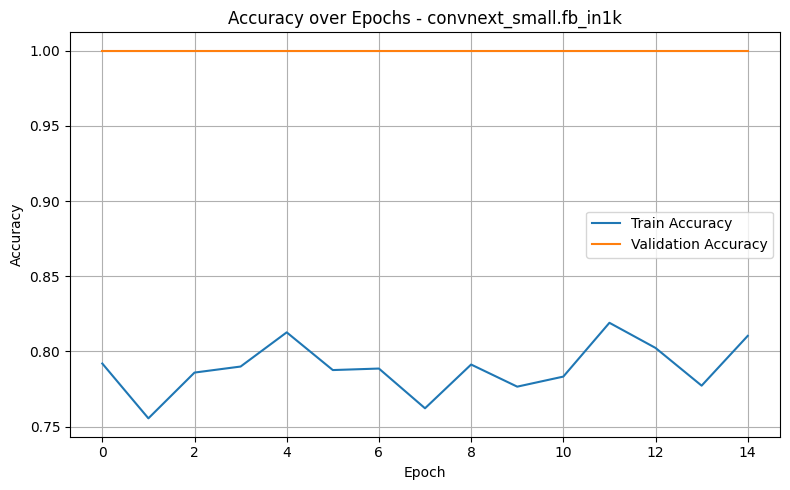

In [26]:
# 🧪 Reload and Evaluate
checkpoint_path = CHECKPOINT_DIR / f"{model_name}_best.pth"
# model = create_model(model_name, pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
model = ExtendedModel(model_name, num_aux_features=3, num_classes=NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load(checkpoint_path))

test_loader = DataLoader(
    SharedHeadDataset(TEST_CSV, ROOT_DIR),
    batch_size=BATCH_SIZE,
    collate_fn=collate_fun
)

_, _, _, _, cm = evaluate_model(model, test_loader)
print("Confusion Matrix:\n", cm)

# 📉 Plot Metrics
plot_metrics(train_accs, val_accs, model_name)

### TRAINING PIPELINE - WITH STRATIFIED 5 FOLD CROSS VALIDATION 

In [27]:
# Model Training Wrapper - Updated checkpoint logic
def train_model(model_name, train_csv, test_csv, root_dir, save_path):
    train_ds = SharedHeadDataset(train_csv, root_dir)
    test_ds = SharedHeadDataset(test_csv, root_dir)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fun, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fun, pin_memory=True)

    model = ExtendedModel(model_name).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
    scaler = GradScaler()

    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_train_acc = 0.0
    previous_logits = None

    for epoch in range(EPOCHS):
        print(f"\n[ Epoch {epoch+1}/{EPOCHS} ]")
        model.train()
        correct, total = 0, 0
        progress = tqdm(train_loader, desc=f"Training {model_name}", leave=False)

        for images, aux, labels in progress:
            images, aux, labels = images.to(DEVICE), aux.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if USE_MIXUP:
                images, targets_a, targets_b, lam = mixup_data(images, labels, ALPHA_MIXUP)

            with autocast(device_type='cuda'):
                outputs = model(images, aux)
                if USE_MIXUP:
                    loss = mixup_criterion(outputs, targets_a, targets_b, lam)
                else:
                    loss = F.cross_entropy(outputs, labels)

                if previous_logits is not None:
                    soft_targets = F.softmax(previous_logits / TEMPERATURE, dim=1)
                    distill_loss = F.kl_div(F.log_softmax(outputs / TEMPERATURE, dim=1), soft_targets, reduction='batchmean')
                    loss += 0.5 * distill_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{correct / total:.4f}"})

        train_acc = correct / total
        val_acc, _, _, _, _ = evaluate_model(model, test_loader)

        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Save checkpoint if train_acc or val_acc improves
        if (train_acc > best_train_acc) or (val_acc > best_val_acc):
            best_train_acc = max(best_train_acc, train_acc)
            best_val_acc = max(best_val_acc, val_acc)
            torch.save(model.state_dict(), CHECKPOINT_DIR / f"{model_name}_best.pth")

        scheduler.step(epoch)
        torch.cuda.empty_cache()
        gc.collect()

    torch.save(model.state_dict(), save_path)
    return model, train_accs, val_accs

## TRAINING PIPELINE - WITH STRATIFIED 5 FOLD CROSS VALIDATION 

#### Using EarlyStopping

In [58]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.001, verbose=True):
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        torch.save(model.state_dict(), path)
        self.val_loss_min = val_loss

In [59]:
def train_model(model_name, train_csv, test_csv, root_dir, save_path):
    train_ds = SharedHeadDataset(train_csv, root_dir)
    test_ds = SharedHeadDataset(test_csv, root_dir)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fun, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, collate_fn=collate_fun, pin_memory=True)

    model = ExtendedModel(model_name).to(DEVICE)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    # NEW 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=3, T_mult=1, eta_min=1e-5
    )

    scaler = GradScaler()
    
    early_stopper = EarlyStopping(patience=5, delta=0.001, verbose=True)
    early_stop_path = CHECKPOINT_DIR / f"{model_name}_earlystop_best.pth"

    train_accs, val_accs = [], []
    best_val_acc = 0.0
    best_train_acc = 0.0
    previous_logits = None

    for epoch in range(EPOCHS):
        print(f"\n[ Epoch {epoch+1}/{EPOCHS} ]")
        model.train()
        correct, total = 0, 0
        progress = tqdm(train_loader, desc=f"Training {model_name}", leave=False)

        for images, aux, labels in progress:
            images, aux, labels = images.to(DEVICE), aux.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if USE_MIXUP:
                images, targets_a, targets_b, lam = mixup_data(images, labels, ALPHA_MIXUP)

            with autocast(device_type='cuda'):
                outputs = model(images, aux)
                if USE_MIXUP:
                    loss = mixup_criterion(outputs, targets_a, targets_b, lam)
                else:
                    loss = F.cross_entropy(outputs, labels)

                if previous_logits is not None:
                    soft_targets = F.softmax(previous_logits / TEMPERATURE, dim=1)
                    distill_loss = F.kl_div(F.log_softmax(outputs / TEMPERATURE, dim=1), soft_targets, reduction='batchmean')
                    loss += 0.5 * distill_loss

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress.set_postfix({"loss": f"{loss.item():.4f}", "acc": f"{correct / total:.4f}"})

        train_acc = correct / total
        val_acc, _, _, _, _ = evaluate_model(model, test_loader)
        
        model.eval()
        val_loss_total = 0.0
        with torch.no_grad():
            for images, aux, labels in test_loader:
                images, aux, labels = images.to(DEVICE), aux.to(DEVICE), labels.to(DEVICE)
                outputs = model(images, aux)
                val_loss_total += F.cross_entropy(outputs, labels, label_smoothing=0.1).item()
        val_loss_avg = val_loss_total / len(test_loader)


        train_accs.append(train_acc)
        val_accs.append(val_acc)
        print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # # Save checkpoint if train_acc or val_acc improves
        # if (train_acc > best_train_acc) or (val_acc > best_val_acc):
        #     best_train_acc = max(best_train_acc, train_acc)
        #     best_val_acc = max(best_val_acc, val_acc)
        #     torch.save(model.state_dict(), CHECKPOINT_DIR / f"{model_name}_best.pth")
        
        early_stopper(val_loss_avg, model, early_stop_path)
        if early_stopper.early_stop:
            print("🔁 Early stopping triggered. Halting training.")
            break


        scheduler.step(epoch)
        torch.cuda.empty_cache()
        gc.collect()

    # Save latest model for reference
    torch.save(model.state_dict(), save_path)

    # Load best checkpoint if early stopping occurred
    if early_stopper.early_stop:
        model.load_state_dict(torch.load(early_stop_path))

    return model, train_accs, val_accs


In [60]:
model_configs = [
    ("swin_small_patch4_window7_224.ms_in1k", "swin_model.pth"),
    ("coatnet_1_rw_224.sw_in1k", "coatnet_model.pth"),
    ("convnext_small.fb_in1k", "convnext_model.pth")
]

In [61]:
from sklearn.model_selection import StratifiedKFold

# Run Stratified K-Fold Training
full_df = pd.read_csv(OUTPUT_DIR / "train_split_augmented.csv")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ConvNeXt Model

In [62]:
model_id = 2  # Example: ConvNeXt
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]
save_path = ROOT_DIR / "models" / history.split('.')[0]
plot_save_path = Path("C:/Users/rsriram3/Documents/ind_study/test-IIM") / "figures" / "shared_head_figures" / history.split('.')[0]
plot_save_path.mkdir(parents=True, exist_ok=True)

In [63]:
# Create folds directory
FOLDS_DIR = OUTPUT_DIR / "folds"
FOLDS_DIR.mkdir(parents=True, exist_ok=True)


 Fold 1 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.6801 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.8038 | Val Acc: 1.0000
EarlyStopping counter: 1 of 5

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.8047 | Val Acc: 1.0000
EarlyStopping counter: 2 of 5

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7549 | Val Acc: 1.0000
EarlyStopping counter: 3 of 5

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.8097 | Val Acc: 1.0000
EarlyStopping counter: 4 of 5

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7829 | Val Acc: 1.0000
EarlyStopping counter: 5 of 5
🔁 Early stopping triggered. Halting training.


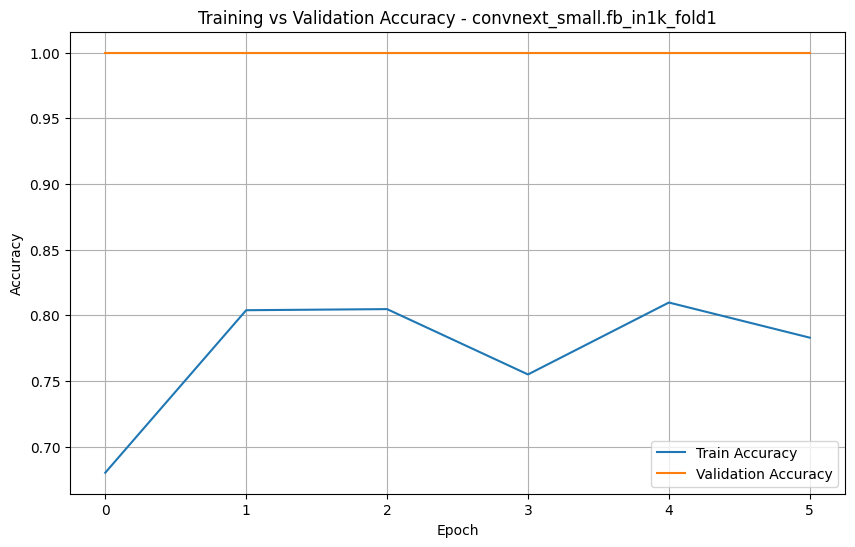


 Fold 2 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7792 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7917 | Val Acc: 1.0000
EarlyStopping counter: 1 of 5

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7871 | Val Acc: 1.0000
EarlyStopping counter: 2 of 5

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7666 | Val Acc: 1.0000
EarlyStopping counter: 3 of 5

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7884 | Val Acc: 1.0000
EarlyStopping counter: 4 of 5

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7746 | Val Acc: 1.0000
EarlyStopping counter: 5 of 5
🔁 Early stopping triggered. Halting training.


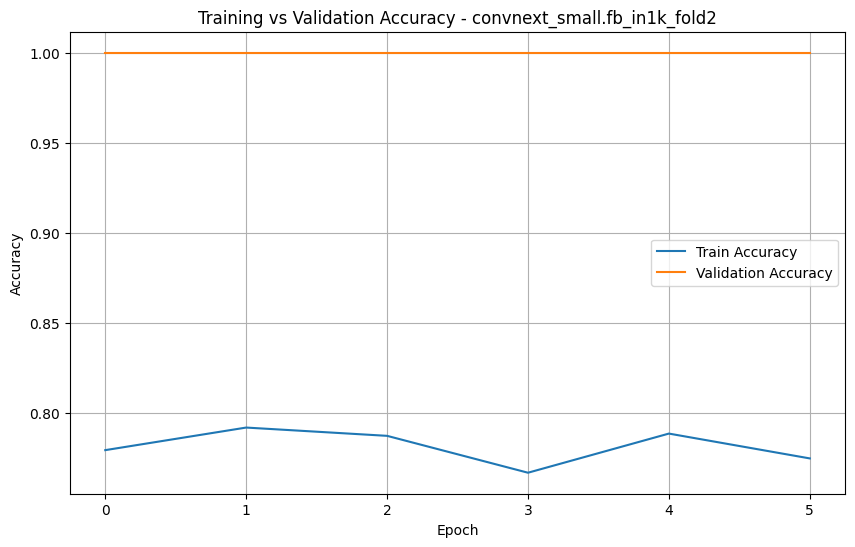


 Fold 3 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7574 | Val Acc: 0.9967

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7771 | Val Acc: 1.0000
EarlyStopping counter: 1 of 5

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7704 | Val Acc: 1.0000
EarlyStopping counter: 2 of 5

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.8001 | Val Acc: 0.9983
EarlyStopping counter: 3 of 5

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7440 | Val Acc: 1.0000
EarlyStopping counter: 4 of 5

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7319 | Val Acc: 1.0000
EarlyStopping counter: 5 of 5
🔁 Early stopping triggered. Halting training.


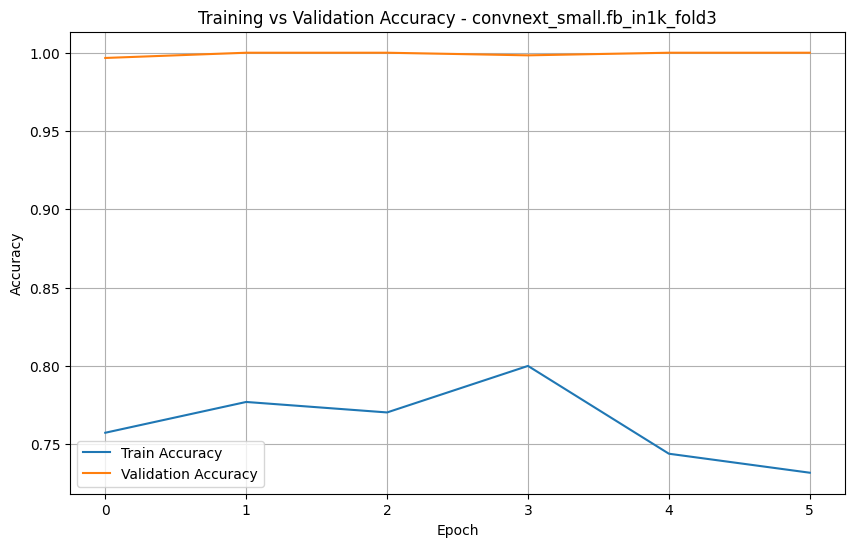


 Fold 4 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7633 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.8009 | Val Acc: 1.0000
EarlyStopping counter: 1 of 5

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7666 | Val Acc: 1.0000
EarlyStopping counter: 2 of 5

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.8018 | Val Acc: 1.0000
EarlyStopping counter: 3 of 5

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.8084 | Val Acc: 1.0000
EarlyStopping counter: 4 of 5

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7583 | Val Acc: 1.0000
EarlyStopping counter: 5 of 5
🔁 Early stopping triggered. Halting training.


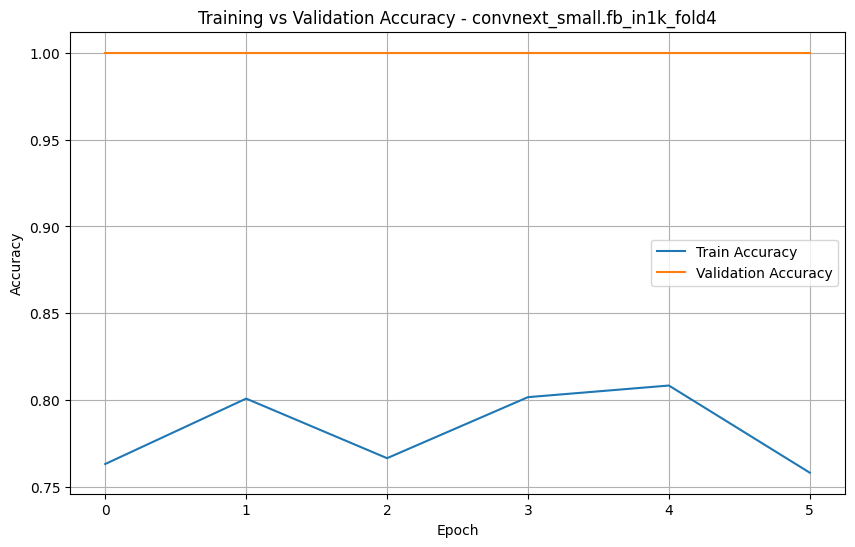


 Fold 5 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7320 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7868 | Val Acc: 1.0000
EarlyStopping counter: 1 of 5

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7550 | Val Acc: 1.0000
EarlyStopping counter: 2 of 5

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7797 | Val Acc: 1.0000
EarlyStopping counter: 3 of 5

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.8491 | Val Acc: 1.0000
EarlyStopping counter: 4 of 5

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.8002 | Val Acc: 1.0000
EarlyStopping counter: 5 of 5
🔁 Early stopping triggered. Halting training.


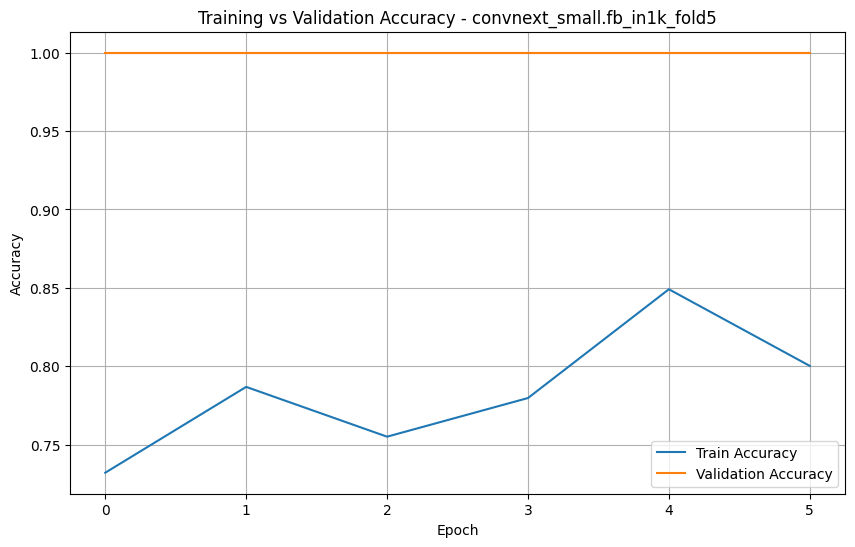

In [64]:
for fold, (train_idx, val_idx) in enumerate(skf.split(full_df, full_df['label'])):
    print(f"\n Fold {fold + 1} ")
    # Get folds
    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    # Save folds as CSVs
    train_fold_path = FOLDS_DIR / f"{history}_train_fold_{fold+1}.csv"
    val_fold_path = FOLDS_DIR / f"{history}_val_fold_{fold+1}.csv"
    train_df.to_csv(train_fold_path, index=False)
    val_df.to_csv(val_fold_path, index=False)

    # Call training using paths
    save_path.mkdir(parents=True, exist_ok=True)
    model_save_path = save_path / f"{model_name}_fold{fold+1}.pth"
    model, train_accs, val_accs = train_model(model_name, train_fold_path, val_fold_path, ROOT_DIR, model_save_path)

    # Plot
    plot_metrics(train_accs, val_accs, f"{model_name}_fold{fold+1}", plot_save_path)


# SWIN Transformer

In [ ]:
model_id = 0  # Example: SWIN Transformer
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]
save_path = ROOT_DIR / "models" / history.split('.')[0]
plot_save_path = Path("C:/Users/rsriram3/Documents/ind_study/test-IIM") / "figures" / "shared_head_figures" / history.split('.')[0]
plot_save_path.mkdir(parents=True, exist_ok=True)

In [13]:
# Create folds directory
FOLDS_DIR = OUTPUT_DIR / "folds"
FOLDS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(full_df, full_df['label'])):
    print(f"\n Fold {fold + 1} ")
    # Get folds
    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    # Save folds as CSVs
    train_fold_path = FOLDS_DIR / f"{history}_train_fold_{fold+1}.csv"
    val_fold_path = FOLDS_DIR / f"{history}_val_fold_{fold+1}.csv"
    train_df.to_csv(train_fold_path, index=False)
    val_df.to_csv(val_fold_path, index=False)

    # Call training using paths
    save_path.mkdir(parents=True, exist_ok=True)
    model_save_path = save_path / f"{model_name}_fold{fold+1}.pth"
    model, train_accs, val_accs = train_model(model_name, train_fold_path, val_fold_path, ROOT_DIR, model_save_path)

    # Plot
    plot_metrics(train_accs, val_accs, f"{model_name}_fold{fold+1}", plot_save_path)


 Fold 1 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7825 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7771 | Val Acc: 1.0000

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7934 | Val Acc: 1.0000

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7955 | Val Acc: 1.0000

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.8164 | Val Acc: 1.0000

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7854 | Val Acc: 1.0000

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.7344 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7361 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.7637 | Val Acc: 1.0000

[ Epoch 10/15 ]


KeyboardInterrupt: 

## TINY-VIT MODEL

In [ ]:
model_configs = [
    ("swin_small_patch4_window7_224.ms_in1k", "swin_model.pth"),
    ("coatnet_1_rw_224.sw_in1k", "coatnet_model.pth"),
    ("convnext_small.fb_in1k", "convnext_model.pth"),
    ("tiny_vit_5m_224.dist_in22k_ft_in1k", "tiny_vit_model.pth"),
]

# tiny_vit_5m_224, tiny_vit_11m_224, tiny_vit_21m_224
# levit_128s, levit_128, levit_192, levit_256
# efficientformer_l1, efficientformer_l3
# edgenext_xx_small, edgenext_x_small, edgenext_small
# mobilevitv2_050, mobilevitv2_075, mobilevitv2_100


In [ ]:
model_id = 3  # Example: SWIN Transformer
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]
save_path = ROOT_DIR / "models" / history.split('.')[0]
plot_save_path = Path("C:/Users/rsriram3/Documents/ind_study/test-IIM") / "figures" / "shared_head_figures" / history.split('.')[0]
plot_save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(full_df, full_df['label'])):
    print(f"\n Fold {fold + 1} ")
    # Get folds
    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    # Save folds as CSVs
    train_fold_path = FOLDS_DIR / f"{history}_train_fold_{fold+1}.csv"
    val_fold_path = FOLDS_DIR / f"{history}_val_fold_{fold+1}.csv"
    train_df.to_csv(train_fold_path, index=False)
    val_df.to_csv(val_fold_path, index=False)

    # Call training using paths
    save_path.mkdir(parents=True, exist_ok=True)
    model_save_path = save_path / f"{model_name}_fold{fold+1}.pth"
    model, train_accs, val_accs = train_model(model_name, train_fold_path, val_fold_path, ROOT_DIR, model_save_path)

    # Plot
    plot_metrics(train_accs, val_accs, f"{model_name}_fold{fold+1}", plot_save_path)


 Fold 1 

[ Epoch 1/15 ]


KeyboardInterrupt: 

## EDGENEXT XX MODEL

In [40]:
model_configs = [
    ("swin_small_patch4_window7_224.ms_in1k", "swin_model.pth"),
    ("coatnet_1_rw_224.sw_in1k", "coatnet_model.pth"),
    ("convnext_small.fb_in1k", "convnext_model.pth"),
    ("tiny_vit_5m_224.dist_in22k_ft_in1k", "tiny_vit_model.pth"),
    ("edgenext_xx_small.in1k", "edgenext_xx_model.pth")
]

# tiny_vit_5m_224, tiny_vit_11m_224, tiny_vit_21m_224
# levit_128s, levit_128, levit_192, levit_256
# efficientformer_l1, efficientformer_l3
# edgenext_xx_small, edgenext_x_small, edgenext_small
# mobilevitv2_050, mobilevitv2_075, mobilevitv2_100


In [55]:
model_id = 4  # Example: edgenext_xx_model
model_name = model_configs[model_id][0]
history = model_configs[model_id][1]
save_path = ROOT_DIR / "models" / history.split('.')[0]
plot_save_path = Path("C:/Users/rsriram3/Documents/ind_study/test-IIM") / "figures" / "shared_head_figures" / history.split('.')[0]
plot_save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(full_df, full_df['label'])):
    print(f"\n Fold {fold + 1} ")
    # Get folds
    train_df = full_df.iloc[train_idx]
    val_df = full_df.iloc[val_idx]

    # Save folds as CSVs
    train_fold_path = FOLDS_DIR / f"{history}_train_fold_{fold+1}.csv"
    val_fold_path = FOLDS_DIR / f"{history}_val_fold_{fold+1}.csv"
    train_df.to_csv(train_fold_path, index=False)
    val_df.to_csv(val_fold_path, index=False)

    # Call training using paths
    save_path.mkdir(parents=True, exist_ok=True)
    model_save_path = save_path / f"{model_name}_fold{fold+1}.pth"
    model, train_accs, val_accs = train_model(model_name, train_fold_path, val_fold_path, ROOT_DIR, model_save_path)

    # Plot
    plot_metrics(train_accs, val_accs, f"{model_name}_fold{fold+1}", plot_save_path)



 Fold 1 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.6826 | Val Acc: 1.0000

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7578 | Val Acc: 1.0000

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7767 | Val Acc: 1.0000

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7892 | Val Acc: 1.0000

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7846 | Val Acc: 1.0000

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7654 | Val Acc: 1.0000

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.7591 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7683 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.7821 | Val Acc: 1.0000

[ Epoch 10/15 ]


Epoch 10 | Train Acc: 0.7808 | Val Acc: 1.0000

[ Epoch 11/15 ]


Epoch 11 | Train Acc: 0.7917 | Val Acc: 1.0000

[ Epoch 12/15 ]


Epoch 12 | Train Acc: 0.8135 | Val Acc: 1.0000

[ Epoch 13/15 ]


Epoch 13 | Train Acc: 0.7896 | Val Acc: 1.0000

[ Epoch 14/15 ]


Epoch 14 | Train Acc: 0.7662 | Val Acc: 1.0000

[ Epoch 15/15 ]


Epoch 15 | Train Acc: 0.7917 | Val Acc: 1.0000

 Fold 2 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7817 | Val Acc: 0.9933

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7997 | Val Acc: 0.9983

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.8139 | Val Acc: 0.9967

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7725 | Val Acc: 1.0000

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7796 | Val Acc: 1.0000

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7503 | Val Acc: 1.0000

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.8055 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7662 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.7616 | Val Acc: 1.0000

[ Epoch 10/15 ]


Epoch 10 | Train Acc: 0.7792 | Val Acc: 1.0000

[ Epoch 11/15 ]


Epoch 11 | Train Acc: 0.7863 | Val Acc: 1.0000

[ Epoch 12/15 ]


Epoch 12 | Train Acc: 0.7762 | Val Acc: 1.0000

[ Epoch 13/15 ]


Epoch 13 | Train Acc: 0.7604 | Val Acc: 1.0000

[ Epoch 14/15 ]


Epoch 14 | Train Acc: 0.8001 | Val Acc: 1.0000

[ Epoch 15/15 ]


Epoch 15 | Train Acc: 0.8206 | Val Acc: 1.0000

 Fold 3 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.6796 | Val Acc: 0.9983

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7942 | Val Acc: 0.9967

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7946 | Val Acc: 0.9967

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7796 | Val Acc: 0.9983

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7449 | Val Acc: 0.9983

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7813 | Val Acc: 0.9967

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.7624 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7988 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.7921 | Val Acc: 0.9983

[ Epoch 10/15 ]


Epoch 10 | Train Acc: 0.7951 | Val Acc: 0.9983

[ Epoch 11/15 ]


Epoch 11 | Train Acc: 0.8327 | Val Acc: 1.0000

[ Epoch 12/15 ]


Epoch 12 | Train Acc: 0.7629 | Val Acc: 0.9983

[ Epoch 13/15 ]


Epoch 13 | Train Acc: 0.7884 | Val Acc: 1.0000

[ Epoch 14/15 ]


Epoch 14 | Train Acc: 0.7687 | Val Acc: 0.9983

[ Epoch 15/15 ]


Epoch 15 | Train Acc: 0.7775 | Val Acc: 0.9983

 Fold 4 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7265 | Val Acc: 0.9967

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7972 | Val Acc: 0.9933

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.7562 | Val Acc: 1.0000

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7704 | Val Acc: 1.0000

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.8026 | Val Acc: 1.0000

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7988 | Val Acc: 1.0000

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.8381 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7491 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.7892 | Val Acc: 1.0000

[ Epoch 10/15 ]


Epoch 10 | Train Acc: 0.7750 | Val Acc: 0.9967

[ Epoch 11/15 ]


Epoch 11 | Train Acc: 0.8093 | Val Acc: 1.0000

[ Epoch 12/15 ]


Epoch 12 | Train Acc: 0.7654 | Val Acc: 1.0000

[ Epoch 13/15 ]


Epoch 13 | Train Acc: 0.7796 | Val Acc: 1.0000

[ Epoch 14/15 ]


Epoch 14 | Train Acc: 0.7558 | Val Acc: 1.0000

[ Epoch 15/15 ]


Epoch 15 | Train Acc: 0.7758 | Val Acc: 1.0000

 Fold 5 

[ Epoch 1/15 ]


Epoch 1 | Train Acc: 0.7717 | Val Acc: 0.9983

[ Epoch 2/15 ]


Epoch 2 | Train Acc: 0.7897 | Val Acc: 1.0000

[ Epoch 3/15 ]


Epoch 3 | Train Acc: 0.8089 | Val Acc: 1.0000

[ Epoch 4/15 ]


Epoch 4 | Train Acc: 0.7910 | Val Acc: 1.0000

[ Epoch 5/15 ]


Epoch 5 | Train Acc: 0.7897 | Val Acc: 1.0000

[ Epoch 6/15 ]


Epoch 6 | Train Acc: 0.7408 | Val Acc: 1.0000

[ Epoch 7/15 ]


Epoch 7 | Train Acc: 0.8219 | Val Acc: 1.0000

[ Epoch 8/15 ]


Epoch 8 | Train Acc: 0.7993 | Val Acc: 1.0000

[ Epoch 9/15 ]


Epoch 9 | Train Acc: 0.8060 | Val Acc: 1.0000

[ Epoch 10/15 ]


Epoch 10 | Train Acc: 0.8094 | Val Acc: 1.0000

[ Epoch 11/15 ]


Epoch 11 | Train Acc: 0.8018 | Val Acc: 1.0000

[ Epoch 12/15 ]


Epoch 12 | Train Acc: 0.8052 | Val Acc: 1.0000

[ Epoch 13/15 ]


Epoch 13 | Train Acc: 0.7759 | Val Acc: 1.0000

[ Epoch 14/15 ]


Epoch 14 | Train Acc: 0.7814 | Val Acc: 1.0000

[ Epoch 15/15 ]


Epoch 15 | Train Acc: 0.8127 | Val Acc: 1.0000
